In [226]:
#!pip install optuna

In [242]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error

In [243]:
# load dataset
path='/content/drive/MyDrive/predicting-student-scores/data/'
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
submission = pd.read_csv(path+'sample_submission.csv')

## EDA 1
- 결측값 있는지 체크

In [244]:
# EDA
train.head()

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0


In [245]:
train.isnull().sum() #결측값 개수 세기

,0
id,0
age,0
gender,0
course,0
study_hours,0
class_attendance,0
internet_access,0
sleep_hours,0
sleep_quality,0
study_method,0


In [246]:
#순서형 변수는 직접 매핑으로 변경
ordinal_map={
    'sleep_quality':{'poor':0,'average':1,'good':2},
    'exam_difficulty':{'easy':0,'moderate':1,'hard':2},
    'facility_rating': {'low': 0, 'medium': 1, 'high': 2},
    'internet_access': {'no': 0, 'yes': 1}# internet_access도 yes/no니까 순서라기보단 0/1로 바꾸는 게 직관적
}

for col, mapping in ordinal_map.items():
  train[col]=train[col].map(mapping)
  test[col]=test[col].map(mapping)

In [247]:
#preprocessing
le = LabelEncoder()

remaining_cols = train.select_dtypes(include=['object']).columns #object 타입 컬럼만 고르기
print(f'자동 인코딩할 나머지 cols: \n{list(remaining_cols)}')
for col in remaining_cols:
  train_values = set(train[col].astype(str).unique())
  test_values = set(test[col].astype(str).unique())

  all_labels = list(train_values | test_values) #합집합임 -> 중복 제거 된다.
  print(all_labels)

  le.fit(all_labels)
  train[col]=le.transform(train[col].astype(str))
  if col in test.columns:
    test[col]=le.transform(test[col].astype(str))

자동 인코딩할 나머지 cols: 
['gender', 'course', 'study_method']
['female', 'other', 'male']
['bba', 'bca', 'b.sc', 'b.tech', 'b.com', 'ba', 'diploma']
['coaching', 'group study', 'self-study', 'online videos', 'mixed']


## EDA 2

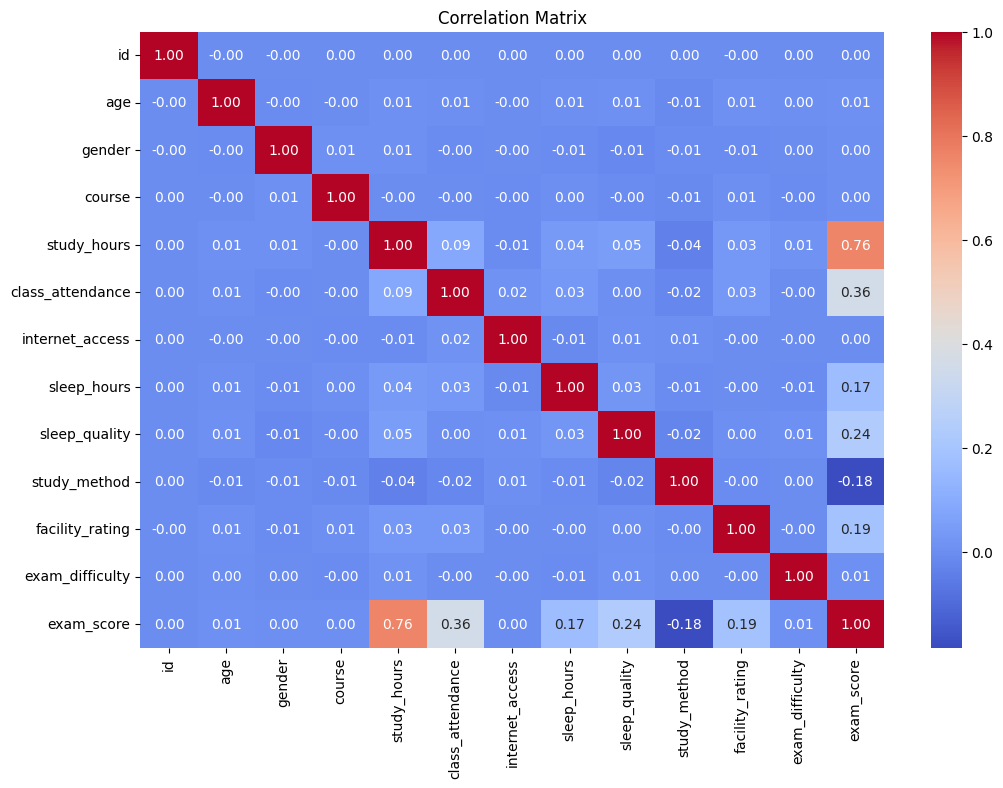

In [248]:
plt.figure(figsize=(12, 8))
corr_matrix = train.corr()

# 히트맵 그리기
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [249]:
# ---------------------------------------------------------
# Feature Engineering: 난이도(Difficulty)와 공부시간(Study Hours)의 상호작용
# ---------------------------------------------------------

# # 1. [나눗셈 가설] 난이도가 높을수록 점수 따기 힘들다 (Study Efficiency)
# # (difficulty는 0, 1, 2니까 +1을 해서 1, 2, 3으로 만들어 나눕니다)
# train['study_efficiency'] = train['study_hours'] / (train['exam_difficulty'] + 1)
# test['study_efficiency'] = test['study_hours'] / (test['exam_difficulty'] + 1)

# # 2. [곱셈 가설] 어려운 시험에 투자한 시간이 더 값지다 (Weighted Study)
# train['study_weighted'] = train['study_hours'] * (train['exam_difficulty'] + 1)
# test['study_weighted'] = test['study_hours'] * (test['exam_difficulty'] + 1)

# # feature engineering : 컬럼끼리 새로운 연산을 해서 파생변수 생성
# # 기존에 가지고 있던 변수들로 연산

# train['effort_index'] = train['study_hours'] * (train['class_attendance'] / 100)
# test['effort_index'] = test['study_hours'] * (test['class_attendance'] / 100)

# train['effective_study'] = train['study_hours'] * (train['sleep_quality'] + 1) # 0을 곱하면 정보가 사라지니 +1
# test['effective_study'] = test['study_hours'] * (test['sleep_quality'] + 1)

# #3. 과부하 지수 (Study Hours / Sleep Hours)
# #잠을 줄이고 공부만 하는 학생인지 확인
# train['overload'] = train['study_hours'] / (train['sleep_hours'] + 0.1) # 0으로 나누기 방지
# test['overload'] = test['study_hours'] / (test['sleep_hours'] + 0.1)

# # 2. 공부 시간 제곱 (Polynomial)
# train['study_squared'] = train['study_hours'] ** 2
# test['study_squared'] = test['study_hours'] ** 2

# # 상대적 비교
# difficulty_mean_study = train.groupby('exam_difficulty')['study_hours'].transform('mean')
# train['relative_study'] = train['study_hours'] - difficulty_mean_study
# test['relative_study'] = test['study_hours'] - difficulty_mean_study

# # ---------------------------------------------------------
# # 검증: 과연 정답(Score)과 얼마나 친할까?
# # ---------------------------------------------------------
# cols_to_check = ['relative_study','study_hours', 'exam_difficulty', 'study_efficiency', 'study_weighted', 'exam_score','effort_index','effective_study','overload']
# corr_matrix = train[cols_to_check].corr()

# print("--- 변수별 상관관계 확인 ---")
# # 절댓값 기준으로 정렬해서 보여줌 (음의 상관관계도 중요하니까!)
# print(abs(corr_matrix['exam_score']).sort_values(ascending=False))

In [237]:
# # 1. 범주형 변수 조합 (Interaction)
# # 두 상황을 합쳐서 더 세분화된 그룹을 만듭니다.
# train['method_access'] = train['study_method'].astype(str) + '_' + train['internet_access'].astype(str)
# test['method_access'] = test['study_method'].astype(str) + '_' + test['internet_access'].astype(str)

# # 이걸 다시 숫자로 바꿔줘야 모델이 이해하겠죠? (Label Encoding)
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# all_labels = list(set(train['method_access']) | set(test['method_access']))
# le.fit(all_labels)
# train['method_access'] = le.transform(train['method_access'])
# test['method_access'] = le.transform(test['method_access'])

In [250]:
# train['effort_index'] = train['study_hours'] * (train['class_attendance'] / 100)
# test['effort_index'] = test['study_hours'] * (test['class_attendance'] / 100)

# drop_cols = ['effective_study', 'study_weighted', 'overload', 'study_efficiency']
# train = train.drop(columns=drop_cols, errors='ignore')
# test = test.drop(columns=drop_cols, errors='ignore')

In [251]:
# exam_score와 상관관계만 뽑아보기
target_corr = abs(corr_matrix['exam_score']).sort_values(ascending=False)

print("---변수별 중요도(상관관계)---")
print(target_corr)

low_corr_cols = target_corr[target_corr<0.1].index.tolist()

print(f"버릴 변수들 : {low_corr_cols}")

train = train.drop(columns=low_corr_cols)
test = test.drop(columns=low_corr_cols)

---변수별 중요도(상관관계)---
exam_score          1.000000
study_hours         0.762267
class_attendance    0.360954
sleep_quality       0.236895
facility_rating     0.188159
study_method        0.183431
sleep_hours         0.167410
age                 0.010472
exam_difficulty     0.008773
gender              0.004748
course              0.003874
internet_access     0.000447
id                  0.000372
Name: exam_score, dtype: float64
버릴 변수들 : ['age', 'exam_difficulty', 'gender', 'course', 'internet_access', 'id']


In [254]:
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

def objective(trial):
    # 탐색할 파라미터 범위 설정
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0), # L1 규제 (불필요한 변수 무시)
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0), # L2 규제 (과적합 방지)
        'random_state': 42,
        'n_jobs': -1,
        'early_stopping_rounds':100
    }

    model = XGBRegressor(**params)

    # 학습 (Early Stopping 적용)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    preds = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, preds)
    return rmse

# 최적화 실행 (20번 시도)
study = optuna.create_study(direction='minimize')
print("--- 🧠 Optuna가 최적의 파라미터를 찾고 있습니다... ---")
study.optimize(objective, n_trials=30) # 시간이 괜찮다면 30~50회 추천

print("\n==================================")
print(f"🏆 Best RMSE: {study.best_value:.5f}") # 8.82808보다 낮으면 성공!
print("==================================")

[I 2026-01-16 06:00:13,481] A new study created in memory with name: no-name-c5e76501-4677-4074-a49f-002b6d09ff4e


--- 🧠 Optuna가 최적의 파라미터를 찾고 있습니다... ---


[I 2026-01-16 06:02:18,639] Trial 0 finished with value: 8.739990376096003 and parameters: {'n_estimators': 2459, 'max_depth': 4, 'learning_rate': 0.06257505847178242, 'subsample': 0.7989817491465516, 'colsample_bytree': 0.9848015083052811, 'min_child_weight': 4, 'reg_alpha': 0.8405992424012279, 'reg_lambda': 0.9019707324904105}. Best is trial 0 with value: 8.739990376096003.
[I 2026-01-16 06:03:54,666] Trial 1 finished with value: 8.7367085855661 and parameters: {'n_estimators': 2640, 'max_depth': 6, 'learning_rate': 0.04371131250860199, 'subsample': 0.9225838338653687, 'colsample_bytree': 0.8379718693944023, 'min_child_weight': 10, 'reg_alpha': 0.730478953264794, 'reg_lambda': 0.28830686871158917}. Best is trial 1 with value: 8.7367085855661.
[I 2026-01-16 06:05:00,391] Trial 2 finished with value: 8.74340845140403 and parameters: {'n_estimators': 1297, 'max_depth': 6, 'learning_rate': 0.08021564177408659, 'subsample': 0.6967413381385399, 'colsample_bytree': 0.6195227899205299, 'min_


🏆 Best RMSE: 8.73507


In [255]:
print("\n최적의 파라미터로 최종 모델을 학습합니다...")

# 찾은 최적 파라미터 가져오기
best_params = study.best_params
best_params['random_state'] = 42
best_params['n_jobs'] = -1
best_params['early_stopping_rounds'] = 100

final_model = XGBRegressor(**best_params)

# 최종 학습 (검증셋을 사용하여 과적합 방지)
final_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# 예측 수행
final_preds = final_model.predict(X_test)
submission[target_col] = final_preds

# 파일 저장
submission.to_csv('submission_optuna.csv', index=False)
print("\n🎉 완료! 'submission_optuna.csv' 파일이 생성되었습니다.")
print("캐글에 제출하여 점수를 확인해보세요!")


최적의 파라미터로 최종 모델을 학습합니다...

🎉 완료! 'submission_optuna.csv' 파일이 생성되었습니다.
캐글에 제출하여 점수를 확인해보세요!


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 난이도별 점수 분포 확인 (거짓말 탐지기)
plt.figure(figsize=(8, 6))
sns.boxplot(x='exam_difficulty', y='exam_score', data=train, order=['easy', 'moderate', 'hard']) # order는 매핑 전 문자열 기준, 매핑했다면 0, 1, 2
plt.title('Exam Score Distribution by Difficulty')
plt.show()

# 2. 난이도별 공부 시간 확인 (학생들이 난이도에 반응했나?)
plt.figure(figsize=(8, 6))
sns.boxplot(x='exam_difficulty', y='study_hours', data=train, order=['easy', 'moderate', 'hard'])
plt.title('Study Hours Distribution by Difficulty')
plt.show()

### Train, Test

In [240]:
# train, test data
target_col = 'exam_score' #예측해야 할 값. 정답

X = train.drop(columns=['id',target_col],errors='ignore')
y = train[target_col]
X_test = test.drop(columns=['id'],errors='ignore')

In [241]:
# train
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(n_estimators=100, learning_rate=0.05) #default : max_depth=6
model.fit(X_train,y_train)

#validation
predictions = model.predict(X_val)
rmse = root_mean_squared_error(y_val, predictions)
print(f"validation data RMSE SCORE : {rmse:.5f}")

validation data RMSE SCORE : 8.84536


In [ ]:
final_preds = model.predict(X_test)
submission[target_col]= final_preds
submission.to_csv('submission.csv',index=False)

In [ ]:
!git checkout -b experiment

In [ ]:
!git add .
!git commit -m "Using Optuna"
!git push -u origin features/EDA